# Transfer Learning for Image Classification in PyTorch

How a CNN learns ([source](https://developer.nvidia.com/discover/convolutional-neural-network))
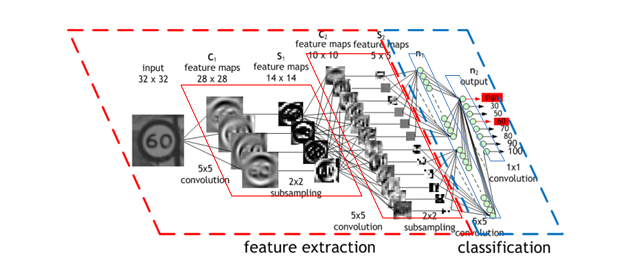

Layer visualization

![cnn-learning](https://miro.medium.com/max/1610/1*WysCJ6Ynecvviwctt6WDlQ.png)

# The Idea Behind transfer Learning
- We take a network(CNN), which is already trained on a very large dataset(Like ImageNet dataset contains lakhs of iamges around 1000 categories). 
- 100 of Model ahs been Trained on ImageNet Dataset by Different comapanies.
- The idea behind transfer learning is that we take one of these models which are already trained called pre-trained model.
- We Use some of the layers of these models to train custom models on custom dataset that we are working with.

## Downloading the Dataset

We'll use the Oxford-IIIT Pets dataset from https://course.fast.ai/datasets . It is 37 category (breeds) pet dataset with roughly 200 images for each class. The images have a large variations in scale, pose and lighting. 

In [1]:
from torchvision.datasets.utils import download_url

In [2]:
# using a direct url
download_url('https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz', '.')

100%|██████████| 811706944/811706944 [00:08<00:00, 94975030.01it/s] 


In [3]:
import tarfile

with tarfile.open('./oxford-iiit-pet.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [4]:
from torch.utils.data import Dataset

In [5]:
import os

DATA_DIR = './data/oxford-iiit-pet/images'

files = os.listdir(DATA_DIR)
len(files) # total number of images

7393

This image folder is different from other image foleder what we have seen soo far.
Here the class is actually the part of the file name.

In [6]:
files[:5]

['yorkshire_terrier_15.jpg',
 'British_Shorthair_86.jpg',
 'japanese_chin_18.jpg',
 'basset_hound_97.jpg',
 'Bengal_97.jpg']

In [7]:
# this is a helper function, which pickup a file name and 
# all it does it is going to take a file name and going to split the file name at '_'
# then its going to get the parts of the file name ignoring the last part of the file name
# xyz_52.jpg -. 52 is going to ignore and then going to join it back using spaces
def parse_breed(fname):
    parts = fname.split('_')
    return ' '.join(parts[:-1])

In [8]:
parse_breed(files[4]) # this is only use to know which type of image the following have. (class of the image)

'Bengal'

In [9]:
from PIL import Image

def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

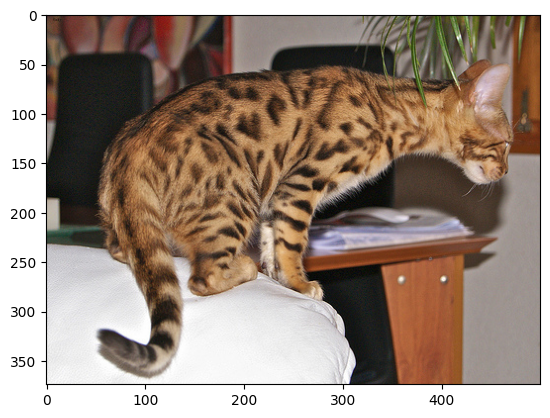

In [10]:
import matplotlib.pyplot as plt
plt.imshow(open_image(os.path.join(DATA_DIR,files[4])))

## Creating a Custom PyTorch Dataset
- now the next step is to create a custom dataset, we can no longer use the image folder dataset bcz all the images are in the same folder there is no different folders per class.
- What we can do is we can create our custom class by extending the dataset class from torch(from torch.util.data we can get Dataset class)

In [11]:
from torch.utils.data import Dataset

The Bellow class requires 3 functions to be implemented.

In [12]:
class PetsDataset(Dataset):
    # root -> rrot dir where the files are contained, and then a transforms need to be applied so that pytorch can understnd the image
    def __init__(self, root, transform):# this is the constructor, formwhere we will the files from the root directory
        super().__init__()
        self.root = root
        # we have only to work on images, so we will take all the list of file name which have extension .jpg
        self.files = [fname for fname in os.listdir(root) if fname.endswith('.jpg')]
        # now setting the parse_bread on each file name, in simple word cahnging the same of each file name, which gives the list of classes of images
        # which will get convert it into set, and the set will remove duplicates and then we will convert it back to the list
        # so the bellow entire line is going to give us the list of the unique classes that are present in teh dataset
        self.classes = list(set(parse_breed(fname) for fname in files))
        # and finally we will also store the transforms
        self.transform = transform
    
    def __len__(self):# this function simply returns the length of the dataset
        return len(self.files)
    
    # to get the ith item, first we get the file name of the ith file and then we will join the root dir with the file name, to get the full path of the file
    def __getitem__(self, i):# this is used to return given an index the ith element from the dataset
        fname = self.files[i]
        fpath = os.path.join(self.root, fname)
        # we will open the image with the full path of the file and whatever transforms have bee passed into our custom class, we will apply those transform the opened image.
        img = self.transform(open_image(fpath))
        # and we will also get teh index of the class
        class_idx = self.classes.index(parse_breed(fname))
        return img, class_idx
        # this is used to make a dataet with image having labels, as our dataset have all the images in same folder

We are going to use the Pre-Trained Model, Trained on Image_Net dataset.
ImageNet dataset contains millions of images belonging to about 1000 classes.
So we are are going to use a model that has been trained there.

In [13]:
import torchvision.transforms as T

img_size = 224 # we will resize the images all at a same dimension

# this stats are taken from the image_net dataset
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
dataset = PetsDataset(DATA_DIR, T.Compose([T.Resize(img_size), 
                                           # adding padding of 8 pixels with reflection mode
                                           T.Pad(8, padding_mode='reflect'),
                                           # then do a random crop
                                           T.RandomCrop(img_size), 
                                           T.ToTensor(), # converting image to tensor
                                           # we will normalize the tensors, a model can have a good understand of images that has been normalize using mean and standard deviation
                                           # as the model which we are going to use is trained on normalize tensor, so this is the main reason of using normalized tensor
                                           T.Normalize(*imagenet_stats)]))

In [14]:
len(dataset)

7390

In [15]:
dataset.classes

['havanese',
 'english setter',
 'basset hound',
 'shiba inu',
 'yorkshire terrier',
 'keeshond',
 'Bengal',
 'Birman',
 'British Shorthair',
 'american bulldog',
 'american pit bull terrier',
 'Sphynx',
 'miniature pinscher',
 'staffordshire bull terrier',
 'Egyptian Mau',
 'pug',
 'Abyssinian',
 'Russian Blue',
 'Maine Coon',
 'leonberger',
 'beagle',
 'Siamese',
 'german shorthaired',
 'scottish terrier',
 'japanese chin',
 'Ragdoll',
 'saint bernard',
 'Persian',
 'great pyrenees',
 'english cocker spaniel',
 'wheaten terrier',
 'pomeranian',
 'samoyed',
 'Bombay',
 'chihuahua',
 'newfoundland',
 'boxer']

In [16]:
len(dataset.classes)

37

We Can also visualize a single image using the defined functions bellow

In [17]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

Label: japanese chin (24)


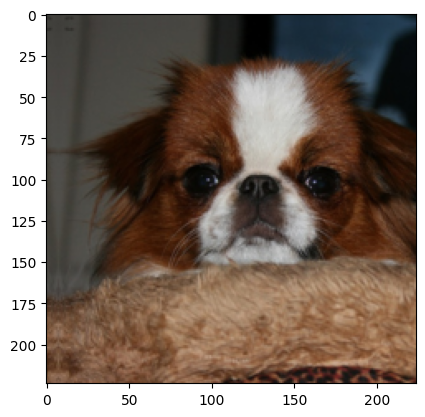

In [18]:
show_image(*dataset[46])

## Creating Training and Validation Sets

In [19]:
from torch.utils.data import random_split

In [20]:
val_pct = 0.1
val_size = int(val_pct * len(dataset)) # using 10% of the dataset as validation set

train_ds, valid_ds = random_split(dataset, [len(dataset) - val_size, val_size])

In [21]:
len(train_ds), len(valid_ds)

(6651, 739)

In [27]:
from torch.utils.data import DataLoader
batch_size = 256

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)

In [28]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], *imagenet_stats)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

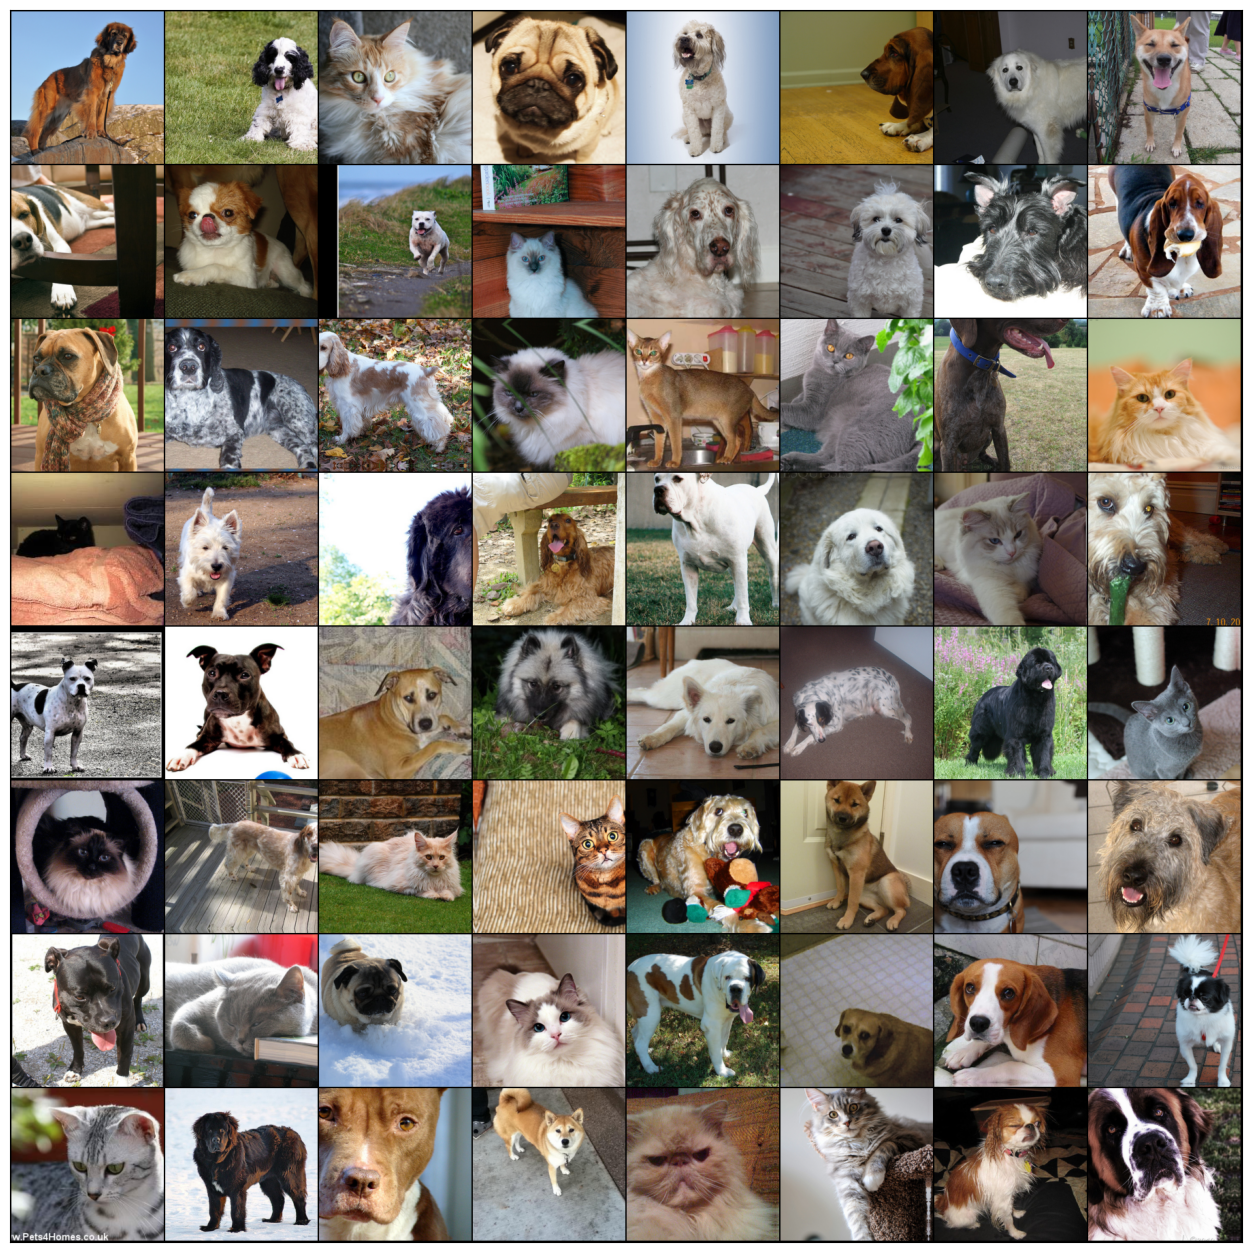

In [29]:
show_batch(train_dl)
# try to use different kind of padding and crpping so that, we can have the proper face or imp feature of the image

## Modifying a Pretrained Model (ResNet34)

Transfer learning ([source](https://mc.ai/transfer-learning-with-deep-learning-machine-learning-techniques/)):
![transfer-learning](https://miro.medium.com/max/1000/1*LUFUl_8fqS97nUzpcFjgWw.png)

In [30]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))

In [31]:
from torchvision import models

class PetsModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained) # this is the model which is already implemented for us, no need ot write it
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [32]:
# models.resnet34()
# for pre-trained model we need to keep the parameter pretrained=True
models.resnet34(pretrained=True) # this resnet is trained on image net dataset
# The weights of the pretrained model is uploaded to pytorch website

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 225MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

This resnet is trained on the image net dataset. If you pass an image into this resnet t will come with a number and the prediction will be a number or prediction will actually be a probabilities for thousands classes. We can pich those probabilities as the highest model and it is making from the classes of imagenet, Which is not very usefull for us, bcz we are working on a differenet dataset and we have only 37 classes not thousands.

So what we want to do, Is to remove the last layer of this resnet34 model and instead we will insert our own last output linear layer or fully connected layer.

And that will have only 37 classes.

## GPU Utilities and Training Loop

In [33]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [34]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


# this is without sheduler
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

    # this is with sheduler, which is adusting learning rate in every epoch
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [35]:
device = get_default_device()
device

device(type='cuda')

In [36]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Finetuning the Pretrained Model

In [45]:
model = PetsModel(len(dataset.classes))
to_device(model, device);

In [46]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 3.7765884399414062, 'val_acc': 0.029339894652366638}]

In [48]:
epochs = 20
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [49]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)
# down we can see, if the ltr is increase acc decreasing
# so its much better to train the model starting from high to low
# not from low to high then to low
# accu reached till 84, mean around 120 image of validation set got missclassified
# this can be happen bcz dataset is cropped in a funny way or we need a good croping factor
# by using this we can reach our model to higher accu

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00100, train_loss: 0.9505, val_loss: 1.4508, val_acc: 0.6082


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00274, train_loss: 0.5774, val_loss: 4.7219, val_acc: 0.2093


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00515, train_loss: 1.0467, val_loss: 6.4791, val_acc: 0.1552


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00757, train_loss: 1.1631, val_loss: 3.6956, val_acc: 0.2049


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00935, train_loss: 1.0794, val_loss: 2.5253, val_acc: 0.3945


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.01000, train_loss: 0.9367, val_loss: 3.1289, val_acc: 0.2811


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [6],last_lr: 0.00987, train_loss: 0.8757, val_loss: 3.0222, val_acc: 0.3364


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [7],last_lr: 0.00950, train_loss: 0.6690, val_loss: 1.9936, val_acc: 0.4625


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [8],last_lr: 0.00891, train_loss: 0.5924, val_loss: 2.2766, val_acc: 0.4662


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [9],last_lr: 0.00812, train_loss: 0.5012, val_loss: 1.7200, val_acc: 0.5740


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [10],last_lr: 0.00717, train_loss: 0.3910, val_loss: 1.4316, val_acc: 0.6444


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [11],last_lr: 0.00611, train_loss: 0.2982, val_loss: 1.0391, val_acc: 0.7067


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [12],last_lr: 0.00500, train_loss: 0.2269, val_loss: 0.8670, val_acc: 0.7463


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [13],last_lr: 0.00389, train_loss: 0.1574, val_loss: 0.8544, val_acc: 0.7614


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [14],last_lr: 0.00283, train_loss: 0.1098, val_loss: 0.6436, val_acc: 0.8164


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [15],last_lr: 0.00188, train_loss: 0.0681, val_loss: 0.6188, val_acc: 0.8184


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [16],last_lr: 0.00109, train_loss: 0.0381, val_loss: 0.5700, val_acc: 0.8480


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [17],last_lr: 0.00050, train_loss: 0.0271, val_loss: 0.5427, val_acc: 0.8436


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [18],last_lr: 0.00013, train_loss: 0.0226, val_loss: 0.5471, val_acc: 0.8504


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [19],last_lr: 0.00000, train_loss: 0.0162, val_loss: 0.5638, val_acc: 0.8443
CPU times: user 1min 16s, sys: 1min 2s, total: 2min 19s
Wall time: 14min 35s


# To know the number of Models here

In [50]:
dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [51]:
# Saving the model
torch.save(model.state_dict(), 'T12_TranferLearningImageNet.pth')

## Training a model from scratch 

Let's repeat the training without using weights from the pretrained ResNet34 model.

In [ ]:
model2 = PetsModel(len(dataset.classes), pretrained=False)
to_device(model2, device);

In [ ]:
history2 = [evaluate(model2, valid_dl)]
history2

In [ ]:
%%time
history2 += fit_one_cycle(epochs, max_lr, model2, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)